**"I / we certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I/we did not receive any external help, coaching, or contributions
during the production of this work."**

In [1374]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage)
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [1375]:
class DQNmodel(nn.Module):
    
    def __init__(self, n_inputs, n_actions, lr,hiddennodes):
        super().__init__()
        self.hNodes = hiddennodes
        self.fc1 = nn.Linear(n_inputs, self.hNodes)
        self.fc2 = nn.Linear(self.hNodes,self.hNodes)
        # self.fc3 = nn.Linear(self.hNodes,self.hNodes)
        self.fc3 = nn.Linear(self.hNodes, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        # x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return x


In [1376]:
class experience:

    def __init__(self):
        self.exp_buffer = []


    def empty_buffer(self):

        self.exp_buffer = []

    def __len__(self):
        return len(self.exp_buffer)


    def log_exp(self, input_vector_s1, action_current, reward,input_vector_s2):
        input_vector_s1 = input_vector_s1.type(torch.float)
        input_vector_s2 = input_vector_s2.type(torch.float)
        action_current = torch.tensor(action_current).type(torch.float)
        reward = torch.tensor(reward).type(torch.float)

        exp_vector = [input_vector_s1, action_current,reward, input_vector_s2]

        self.exp_buffer.append(exp_vector)

    

    def get_exp(self):

        return self.exp_buffer

In [1377]:
"""
  Most Probably the Q learning and sarsa function go over here.
"""

class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space # Observation Space
    self.action_space = env.action_space # Action space

  def epsilon_decay(self, current_eps, decay_factor, min_eps, current_episode, max_eps = 1):
    # Epsilon decay
    eps = max(current_eps*decay_factor, min_eps)
    # eps = min_eps + (max_eps - min_eps)* np.exp(-decay_factor*current_episode)
    return eps  
       
  def step(self, action, render_mode="Deterministic"):
    
    if render_mode == "Deterministic":
        action_step = action
    
    return action_step

In [1378]:
def train_modelM(env, agent,model, exp, eps_init,eps_thresh, epochs, replay_size, batch_size,hnodes, lr ,doubledqn):
  
    # Epsilon decay list for logging
    eps_decay_data = []

    # Score List for logging
    score_data = []

    count_list = []

    # Setting the epsilon value to 1 at start
    eps= eps_init
    j = 0

    loss_list = []

    # Creating the policy model 
    policy = model(env.observation_space.shape[0],env.action_space.n,lr,hnodes)

    # Creating target model
    target = model(env.observation_space.shape[0],env.action_space.n,lr,hnodes)
    
   
    for x in range(epochs):
        
        print(x)

        # Resetting the environment
        obs = env.reset()
        # obs =np.reshape(obs, (1,4))
        
    
        # print(obs)
        input_vector_s1_tensor = torch.from_numpy(obs)
        # print(input_vector_s1_tensor)

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        count = 0

        # While Loop
        while not done:
            
            
            count += 1
            
            
            # Selecting the greedy action or the random action depending the epsilon value
            if eps_thresh < eps:
                # Selecting some random number betwwen the action space 
                action_num = np.random.choice(env.action_space.n)
            else:
                # Selecting the greedy action
                input_vector_s1_tensor = input_vector_s1_tensor.type(torch.float)
                with torch.no_grad():
                    policy.eval()
                    q = policy(input_vector_s1_tensor)
                    action_num = torch.argmax(q).item()
                    # print("This is the Q values ",q, "This is the argmax ", action_num)

            # print(action_num)

            
            # First action that the agent is going to take before the while loop starts
            new_state, reward, done, _ = env.step(action_num)
            input_vector_s2_tensor = torch.from_numpy(new_state)
        
            score +=reward

            
            if count < 30 :
                reward -= 10
            else: 
                reward = -1
            if count > 100:
                reward += 1
            if count > 200:
                reward += 1
            if count > 300:
                reward += 2
            if count > 400:
                reward += 3
            if count > 475:
                reward += 6

            # Appending the experience to the list
            exp.log_exp(input_vector_s1_tensor, action_num, reward, input_vector_s2_tensor)
            input_vector_s1_tensor =input_vector_s2_tensor

            #score += reward
            

            if exp.__len__() >= replay_size:
                j += 1
                #print("Training the model, length of batch size is ", len(exp_replay))
                batch = random.sample(exp.exp_buffer, batch_size)


                s1_batch = torch.stack([st1 for (st1, a1, r , st2) in batch])
                s2_batch = torch.stack([st2 for (st1, a1, r , st2) in batch])
                a_batch = torch.stack([a1 for (st1, a1, r , st2) in batch])
                r_batch = torch.stack([r for (st1, a1, r , st2) in batch])
                

                s1_batch = torch.reshape(s1_batch, (batch_size, 4))
                s2_batch = torch.reshape(s2_batch, (batch_size, 4))

                s1_batch = s1_batch.type(torch.float)
                s2_batch = s2_batch.type(torch.float)
                a_batch = a_batch.type(torch.float)

                policy_q = policy(s1_batch)
                policy_q1=policy(s2_batch)
                
                target_q = target(s2_batch)

                X = policy_q.gather(dim=1, index=a_batch.long().unsqueeze(dim=1)).squeeze()
                if(doubledqn==0):
                    Y = r_batch + disc_factor*(torch.max(target_q, dim=1)[0])
                    # print(torch.max(target_q, dim=1))
                else:
                    Y = r_batch + disc_factor*(torch.max(policy_q1, dim=1)[0])

                #print(r_batch)  
                #print(Y)
                loss  = policy.criterion(X,Y.detach())
                #print(loss)
                policy.optimizer.zero_grad()
                loss.backward()

                loss_list.append(loss.item())
                policy.optimizer.step()
                
                if j % 30== 0:
                    target.load_state_dict(policy.state_dict())

                # Experience Replay
                exp.empty_buffer()

        #print(count)
        count_list.append(count)
        score_data.append(score)
        eps_decay_data.append(eps)
        # Epsilon Decay
        #if eps > min_eps:
            #eps *= decay_factor
        # print(j)
        eps = agent.epsilon_decay(eps,decay_factor, min_eps,x)

    return eps_decay_data, score_data, policy, count_list


In [1379]:

def evaluate_modelM(env, agent, trained_model, eval_epochs):
    # Score List for logging
    score_data1 = []

    # Episodes iteration
    for x in range(eval_epochs):

        # Resetting the environment
        obs = env.reset()
        obs = np.reshape(obs,(-1, 4))

    
        input_vector_s1_tensor = torch.from_numpy(obs)
        

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        env.reset()

        # While loop for the iterations
        while not done:

            with torch.no_grad():
                trained_model.eval()
                action_num = torch.argmax(trained_model(input_vector_s1_tensor.float())).item()

            # Selection the action
            #action_current = agent.step(action_num)
            new_state, reward, done, _ = env.step(action_num)
            new_state = np.reshape(new_state,(-1, 4))

            input_vector_s1_tensor = torch.from_numpy(new_state)
            
            # Adding the reward to the score
            score += reward
            # env.render()
            # time.sleep(0.1)
            
        score_data1.append(score)
    env.close()
    return score_data1

**DQN**

In [1380]:
c = gym.make("CartPole-v1")
c.reset()
print(c.action_space.n)
agent = RandomAgent(c)
exp = experience()
min_eps = 0.01
epochs  = 5000
decay_factor = float((min_eps)**(1/epochs))
disc_factor = 1
replay_size = 3000
batch_size = 128
eps_thresh = 0.6

x3, y3, model3, cl = train_modelM(c, agent, DQNmodel,exp, 1,eps_thresh, epochs, replay_size, batch_size,30, 0.01,0)

2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


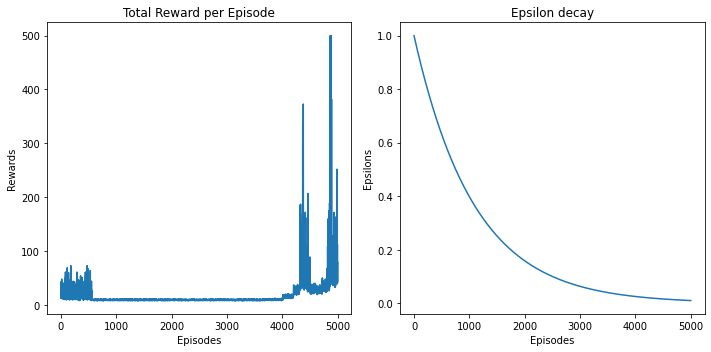

In [1381]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y3))
plt.plot(xn,y3)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(x3))
plt.plot(x1,x3)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

65.74


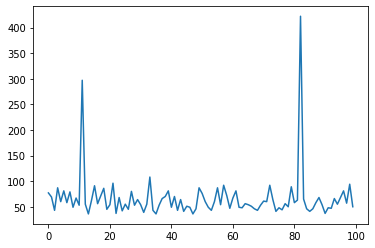

In [1412]:
sd1 = evaluate_modelM(c, agent, model3, 100)
sd1_np = np.asarray(sd1)
avg = np.sum(sd1_np)/len(sd1)
print(avg)
plt.plot(sd1)

In [1411]:
print(model3)

DQNmodel(
  (fc1): Linear(in_features=4, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
  (criterion): MSELoss()
)


**Double DQN**

In [1384]:
c = gym.make("CartPole-v1")
c.reset()
agent = RandomAgent(c)
exp = experience()
min_eps = 0.0001
epochs  = 10000
decay_factor = float((min_eps)**(1/epochs))
disc_factor = 1
replay_size = 500
batch_size = 256
x4, y4, model4, cl = train_modelM(c, agent, DQNmodel,exp, 1, epochs, replay_size, batch_size,120,0.00023,1)

TypeError: train_modelM() missing 1 required positional argument: 'doubledqn'

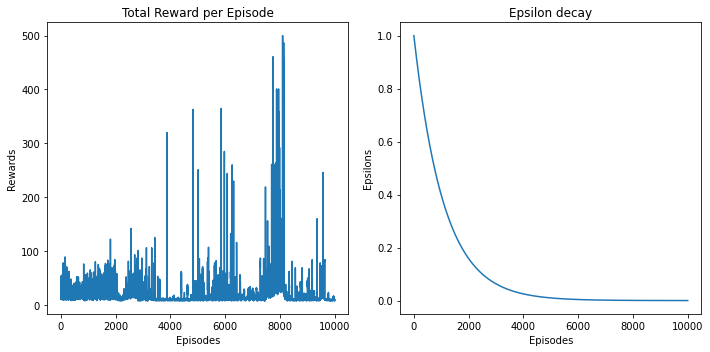

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y4))
plt.plot(xn,y4)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(x4))
plt.plot(x1,x4)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

In [ ]:
for i in range(20):
    print(np.random.choice(2))

1
1
1
1
1
1
1
1
0
1
1
0
0
0
1
0
1
0
1
0
